In [ ]:
!pip install numpy pandas matplotlib seaborn scipy statsmodels gmaps geemap

In [ ]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot
from ipyleaflet import Map, Marker, MarkerCluster, AwesomeIcon
import datetime

In [3]:
df = pd.read_csv('drive/My Drive/mta_1706.csv', error_bad_lines=False, low_memory=False, warn_bad_lines=False)

In [4]:
df.head(13)

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
0,2017-06-01 00:03:34,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,40.635170,-73.960803,FOSTER AV/E 18 ST,approaching,76.0,2017-06-01 00:03:59,24:06:14
1,2017-06-01 00:03:43,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,40.590802,-74.158340,MERRYMOUNT ST/TRAVIS AV,approaching,62.0,2017-06-01 00:03:56,23:58:02
2,2017-06-01 00:03:49,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,40.886010,-73.912647,HENRY HUDSON PKY E/W 235 ST,at stop,5.0,2017-06-01 00:03:56,24:00:53
3,2017-06-01 00:03:31,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,40.668002,-73.729348,HOOK CREEK BL/SUNRISE HY,< 1 stop away,267.0,2017-06-01 00:04:03,24:03:00
4,2017-06-01 00:03:22,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,40.868134,-73.893032,GRAND CONCOURSE/E 196 ST,at stop,11.0,2017-06-01 00:03:56,23:59:38
5,2017-06-01 00:03:40,0,M1,4 AV/E 10 ST,40.731342,-73.990288,HARLEM 147 ST via MADISON,40.821110,-73.935898,NYCT_3831,40.792897,-73.950023,MADISON AV/E 106 ST,approaching,73.0,2017-06-01 00:03:56,24:02:35
6,2017-06-01 00:03:24,0,B31,GERRITSEN AV/GERRITSEN BEACH,40.587101,-73.918503,MIDWOOD KINGS HWY STA,40.608433,-73.957100,NYCT_4611,40.587024,-73.918623,GERRITSEN AV/GERRITSEN BEACH,at stop,0.0,NaN,24:08:00
7,2017-06-01 00:03:29,0,B83,GATEWAY CTR TERM/GATEWAY DR,40.652649,-73.877029,BWAY JCT VN SNDRN AV,40.678139,-73.903572,NYCT_4841,40.648801,-73.882682,PENNSYLVANIA AV/DELMAR LOOP N,< 1 stop away,196.0,2017-06-01 00:04:13,23:58:47
8,2017-06-01 00:03:27,0,B82,STILLWELL TERMINAL BUS LOOP,40.577080,-73.981293,SPRING CRK TWRS SEAVIEW AV via KINGS HWY,40.642990,-73.878326,NYCT_6592,40.632258,-73.918318,FLATLANDS AV/RALPH AV,approaching,35.0,2017-06-01 00:03:56,24:00:00
9,2017-06-01 00:03:51,1,S59,RICHMOND TER/PARK AV #3,40.640167,-74.130966,HYLAN BL,40.534260,-74.154213,NYCT_8279,40.590689,-74.165811,RICHMOND AV/NOME AV,approaching,31.0,2017-06-01 00:03:56,24:01:14


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6730436 entries, 0 to 6730435
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   RecordedAtTime             object 
 1   DirectionRef               int64  
 2   PublishedLineName          object 
 3   OriginName                 object 
 4   OriginLat                  float64
 5   OriginLong                 float64
 6   DestinationName            object 
 7   DestinationLat             float64
 8   DestinationLong            float64
 9   VehicleRef                 object 
 10  VehicleLocation.Latitude   float64
 11  VehicleLocation.Longitude  float64
 12  NextStopPointName          object 
 13  ArrivalProximityText       object 
 14  DistanceFromStop           float64
 15  ExpectedArrivalTime        object 
 16  ScheduledArrivalTime       object 
dtypes: float64(7), int64(1), object(9)
memory usage: 872.9+ MB


**Data Preprocessing**



*   Replacing the null and NaN values of numeric columns with the mean of that column
*   Converting the timestamp columns to datetime datatype
*   Replacing the null and NaN values of 'ExpectedArrivalTime' column with the corresponding value in 'RecordedAtTime' column
*   Replacing the null and NaN values of 'ScheduledArrivalTime' column with the corresponding value in 'ExpectedArrivalTime' column
*   Converting certain erroneous data in 'ScheduledArrivalTime' column of the format '25:00:00' to '00:00:00'
*   Appending dates to 'ScheduledArrivalTime' column:
  *   Same date as that of 'ExpectedArrivalTime' column if difference between 'ScheduledArrivalTime' and 'ExpectedArrivalTime' column is <= 12 hr
  *   1 day less than that of 'ExpectedArrivalTime' column if difference between 'ScheduledArrivalTime' and 'ExpectedArrivalTime' column is > 12 hr
  *   1 day more than that of 'ExpectedArrivalTime' column if difference between 'ExpectedArrivalTime' and 'ScheduledArrivalTime' column is > 12 hr













In [6]:
df['OriginLat'] = df['OriginLat'].fillna(df['OriginLat'].mean())
df['OriginLong'] = df['OriginLong'].fillna(df['OriginLong'].mean())
df['DestinationLat'] = df['DestinationLat'].fillna(df['DestinationLat'].mean())
df['DestinationLong'] = df['DestinationLong'].fillna(df['DestinationLong'].mean())
df['VehicleLocation.Latitude'] = df['VehicleLocation.Latitude'].fillna(df['VehicleLocation.Latitude'].mean())
df['VehicleLocation.Longitude'] = df['VehicleLocation.Longitude'].fillna(df['VehicleLocation.Longitude'].mean())
df['DistanceFromStop'] = df['DistanceFromStop'].fillna(df['DistanceFromStop'].mean())

In [7]:
df['RecordedAtTime'] = pd.to_datetime(df['RecordedAtTime'])

In [8]:
df['ExpectedArrivalTime'] = df['ExpectedArrivalTime'].fillna(df['RecordedAtTime'])

In [9]:
df['ExpectedArrivalTime'] = pd.to_datetime(df['ExpectedArrivalTime'])

In [10]:
df['ScheduledArrivalTime'] = df['ScheduledArrivalTime'].fillna(df['ExpectedArrivalTime'].dt.time)

In [11]:
df['ScheduledArrivalTime'] = np.where(df['ScheduledArrivalTime'].astype(str).str[:2].astype(float) >= 24, (df['ScheduledArrivalTime'].astype(str).str[:2].astype(float)-24).astype(str).str.replace('.0','') + df['ScheduledArrivalTime'].astype(str).str[2:], df['ScheduledArrivalTime'])

In [12]:
df['ScheduledArrivalTime'] = np.where(df['ScheduledArrivalTime'].astype(str).str.len() == 7, df['ScheduledArrivalTime'].astype(str).str.zfill(8), df['ScheduledArrivalTime'])

In [13]:
df['ScheduledArrivalTime'] = np.where((df['ScheduledArrivalTime'].astype(str).str[:2].astype(float) - df['ExpectedArrivalTime'].dt.hour.astype(float)) > 12, (df['ExpectedArrivalTime'].dt.date - datetime.timedelta(days=1)).astype(str) + df['ScheduledArrivalTime'].astype(str).str.rjust(9), df['ScheduledArrivalTime'])

In [14]:
df['ScheduledArrivalTime'] = np.where((df['ExpectedArrivalTime'].dt.hour.astype(float) - df['ScheduledArrivalTime'].astype(str).str[:2].astype(float)) > 12, (df['ExpectedArrivalTime'].dt.date + datetime.timedelta(days=1)).astype(str) + df['ScheduledArrivalTime'].astype(str).str.rjust(9), df['ScheduledArrivalTime'])

In [15]:
df['ScheduledArrivalTime'] = np.where(df['ScheduledArrivalTime'].astype(str).str.len() < 10, ((df['ExpectedArrivalTime'].dt.date).astype(str) + df['ScheduledArrivalTime'].astype(str).str.rjust(9)).astype(str), df['ScheduledArrivalTime'])

In [16]:
df['ScheduledArrivalTime'] = pd.to_datetime(df['ScheduledArrivalTime'])

In [17]:
df.head(12)

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
0,2017-06-01 00:03:34,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,40.635170,-73.960803,FOSTER AV/E 18 ST,approaching,76.0,2017-06-01 00:03:59,2017-06-01 00:06:14
1,2017-06-01 00:03:43,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,40.590802,-74.158340,MERRYMOUNT ST/TRAVIS AV,approaching,62.0,2017-06-01 00:03:56,2017-05-31 23:58:02
2,2017-06-01 00:03:49,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,40.886010,-73.912647,HENRY HUDSON PKY E/W 235 ST,at stop,5.0,2017-06-01 00:03:56,2017-06-01 00:00:53
3,2017-06-01 00:03:31,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,40.668002,-73.729348,HOOK CREEK BL/SUNRISE HY,< 1 stop away,267.0,2017-06-01 00:04:03,2017-06-01 00:03:00
4,2017-06-01 00:03:22,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,40.868134,-73.893032,GRAND CONCOURSE/E 196 ST,at stop,11.0,2017-06-01 00:03:56,2017-05-31 23:59:38
5,2017-06-01 00:03:40,0,M1,4 AV/E 10 ST,40.731342,-73.990288,HARLEM 147 ST via MADISON,40.821110,-73.935898,NYCT_3831,40.792897,-73.950023,MADISON AV/E 106 ST,approaching,73.0,2017-06-01 00:03:56,2017-06-01 00:02:35
6,2017-06-01 00:03:24,0,B31,GERRITSEN AV/GERRITSEN BEACH,40.587101,-73.918503,MIDWOOD KINGS HWY STA,40.608433,-73.957100,NYCT_4611,40.587024,-73.918623,GERRITSEN AV/GERRITSEN BEACH,at stop,0.0,2017-06-01 00:03:24,2017-06-01 00:08:00
7,2017-06-01 00:03:29,0,B83,GATEWAY CTR TERM/GATEWAY DR,40.652649,-73.877029,BWAY JCT VN SNDRN AV,40.678139,-73.903572,NYCT_4841,40.648801,-73.882682,PENNSYLVANIA AV/DELMAR LOOP N,< 1 stop away,196.0,2017-06-01 00:04:13,2017-05-31 23:58:47
8,2017-06-01 00:03:27,0,B82,STILLWELL TERMINAL BUS LOOP,40.577080,-73.981293,SPRING CRK TWRS SEAVIEW AV via KINGS HWY,40.642990,-73.878326,NYCT_6592,40.632258,-73.918318,FLATLANDS AV/RALPH AV,approaching,35.0,2017-06-01 00:03:56,2017-06-01 00:00:00
9,2017-06-01 00:03:51,1,S59,RICHMOND TER/PARK AV #3,40.640167,-74.130966,HYLAN BL,40.534260,-74.154213,NYCT_8279,40.590689,-74.165811,RICHMOND AV/NOME AV,approaching,31.0,2017-06-01 00:03:56,2017-06-01 00:01:14




---



**Categorical Datatype Example**

In [18]:
df.DirectionRef.unique()

array([0, 1])

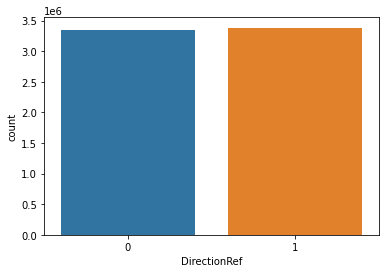

In [19]:
sns.countplot(x='DirectionRef', data=df)
plt.show()



---



**Measures of Central Tendency**

**Mean** of every numeric column(interval and ratio type data) present in the dataset

In [20]:
colMeans = df.drop('DirectionRef', axis=1).mean(axis=0, numeric_only=True)
print(colMeans)

OriginLat                     40.729610
OriginLong                   -73.931110
DestinationLat                40.728634
DestinationLong              -73.931565
VehicleLocation.Latitude      40.728485
VehicleLocation.Longitude    -73.930712
DistanceFromStop             225.881287
dtype: float64




---



**Median** of every numeric column(interval and ratio type data) present in the dataset

In [21]:
colMedians = df.drop('DirectionRef', axis=1).median(axis=0, numeric_only=True)
print(colMedians)

OriginLat                    40.716423
OriginLong                  -73.932449
DestinationLat               40.714531
DestinationLong             -73.932266
VehicleLocation.Latitude     40.723225
VehicleLocation.Longitude   -73.936528
DistanceFromStop             90.000000
dtype: float64




---



**Using Mean and Median**

To find the location which is equidistant from all the bus stops

In [22]:
from math import cos, sin, radians, atan2, sqrt, degrees, pi

pos = pd.DataFrame()

pos["Lat"] = np.hstack((df.OriginLat, df.DestinationLat))
pos["Lat"] = pos.Lat.apply(radians)

pos["Lon"] = np.hstack((df.OriginLong, df.DestinationLong))
pos["Lon"] = pos.Lon.apply(radians)

pos = pos.drop_duplicates()

pos["X"] = np.vectorize(lambda lat, lon: cos(lat)*cos(lon))(pos["Lat"], pos["Lon"])
pos["Y"] = np.vectorize(lambda lat, lon: cos(lat)*sin(lon))(pos["Lat"], pos["Lon"])
pos["Z"] = np.vectorize(sin)(pos["Lat"])

x = pos.X.mean() # pos.X.median()
y = pos.Y.mean() # pos.Y.median()
z = pos.Z.mean() # pos.Z.median()

Center_Lon = atan2(y, x)
Hyp = sqrt(x*x + y*y)
Center_Lat = atan2(z, Hyp)

print(f"Location Equidistant from all bus stops: {degrees(Center_Lat)} N, {-1*degrees(Center_Lon)} W")

Location Equidistant from all bus stops: 40.71775490683684 N, 73.93839068414633 W


The above location remains the same for both **mean** and **median** values



---



To locate the above found location on the map

In [23]:
center = (degrees(Center_Lat),degrees(Center_Lon))

m = Map(center=center, zoom=10)

icon1 = AwesomeIcon(
    name='bus',
    marker_color='red',
    icon_color='white',
    spin=False
)
marker = Marker(location=center, draggable=False, icon=icon1)

icon2 = AwesomeIcon(
    name='bus',
    marker_color='green',
    icon_color='white',
    spin=False
)

markers=list()
markers = ( Marker(location=(degrees(i[0]), degrees(i[1])), draggable=False, icon=icon2) for i in np.array(pos) )

marker_cluster = MarkerCluster( markers=tuple(markers) )

m.add_layer(marker)
m.add_layer(marker_cluster)

display(m)

Map(center=[40.71775490683684, -73.93839068414633], controls=(ZoomControl(options=['position', 'zoom_in_text',…



---



**Mode** of every column present in the dataset(Nominal, interval and ratio type data)

In [24]:
colModes = df.mode(axis=0)
colModes.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
0,2017-06-16 07:58:54,1,B6,E 126 ST/2 AV,40.704906,-73.793304,WASHINGTON HTS GW BRIDGE,40.704933,-73.79332,NYCT_5860,40.714687,-73.831286,W 181 ST/AMSTERDAM AV,approaching,0.0,2017-06-14 11:36:23,2017-06-27 16:27:02




---



**Using Mode**

To find Common Initial(origin) and Final(destination) Stops with respect to directionRef(0 or 1).

In [25]:
origins = [
    df[df.DirectionRef==i]['OriginName'].value_counts().idxmax() 
    for i in df.DirectionRef.unique()
]
print(f"Common Origins:\n\tDir-0: {origins[0]}\n\tDir-1: {origins[1]}\n")

destinations = [
    df[df.DirectionRef==i]['DestinationName'].value_counts().idxmax() 
    for i in df.DirectionRef.unique()
]
print(f"Common Destinations:\n\tDir-0: {destinations[0]}\n\tDir-1: {destinations[1]}\n")

Common Origins:
	Dir-0: MERRICK BL/ARCHER AV
	Dir-1: E 126 ST/2 AV

Common Destinations:
	Dir-0: ST GEORGE FERRY
	Dir-1: WASHINGTON HTS GW BRIDGE





---



To find the most frequent paths from those Initial Stops(origins)

In [26]:
paths_from_origins = list( map( lambda x : 
                               [ 
                                   x,
                                   df[ df.OriginName == x ][ "DestinationName" ].value_counts().idxmax(),
                                   df[ df.OriginName == x ][ "DestinationName" ].value_counts()[0]
                               ],
                               origins
                              )
                         )
print("Most Common Paths from Common Origins:\n")
k=0
for i in paths_from_origins:
    print("\tDirection Reference:", k)
    k+=1
    print("\tFrom:", i[0])
    print("\tTo:", i[1])
    print("\tNo of Trips:", i[2],"\n")

Most Common Paths from Common Origins:

	Direction Reference: 0
	From: MERRICK BL/ARCHER AV
	To: SELECT BUS BRONX ZOO via MAIN ST
	No of Trips: 40732 

	Direction Reference: 1
	From: E 126 ST/2 AV
	To: SELECT BUS SERVICE SOUTH FERRY via 2 AV
	No of Trips: 51015 





---



To find the most frequent paths to those Final Stops(destinations)

In [27]:
paths_to_destinations = list( map( lambda x : 
                               [ 
                                   x,
                                   df[ df.DestinationName == x ][ "OriginName" ].value_counts().idxmax(),
                                   df[ df.DestinationName == x ][ "OriginName" ].value_counts()[0]
                               ],
                               destinations
                              )
                         )

print("\nMost Common Paths to Common Destination:\n")
k=0
for i in paths_to_destinations:
    print("\tDirection Reference:", k)
    k+=1
    print("\tFrom:", i[0])
    print("\tTo:", i[1])
    print("\tNo of Trips:", i[2],"\n")


Most Common Paths to Common Destination:

	Direction Reference: 0
	From: ST GEORGE FERRY
	To: YUKON AV/KMART DWY
	No of Trips: 21421 

	Direction Reference: 1
	From: WASHINGTON HTS GW BRIDGE
	To: RANDALL AV/OLMSTEAD AV
	No of Trips: 30743 





---



To find the number of buses from the above initial stops to the final stops

In [28]:
ini_stop_0 = df[df["DirectionRef"]==0]['OriginName'].mode().get(0)
ini_stop_1 = df[df["DirectionRef"]==1]['OriginName'].mode().get(0)
fin_stop_1 = df[df["DirectionRef"]==1]['DestinationName'].mode().get(0)
fin_stop_0 = df[df["DirectionRef"]==0]['DestinationName'].mode().get(0)

The most frequent path with DirectionRef = 0

In [29]:
(df[df["DirectionRef"]==0][df['OriginName']==ini_stop_0].mode())[["OriginName", "DestinationName"]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,OriginName,DestinationName
0,MERRICK BL/ARCHER AV,SELECT BUS BRONX ZOO via MAIN ST


The most frequent path with DirectionRef = 1

In [30]:
(df[df["DirectionRef"]==1][df['OriginName']==ini_stop_1].mode())[["OriginName", "DestinationName"]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,OriginName,DestinationName
0,E 126 ST/2 AV,SELECT BUS SERVICE SOUTH FERRY via 2 AV


To find the number of buses for the above paths

In [31]:
print(df[df["DirectionRef"]==0][df['OriginName']==ini_stop_0][["OriginName", "DestinationName"]][df.DestinationName==fin_stop_0].count(),"\n")
print(df[df["DirectionRef"]==0][df['OriginName']==ini_stop_0][["OriginName", "DestinationName"]][df.DestinationName==fin_stop_1].count())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


OriginName         0
DestinationName    0
dtype: int64 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


OriginName         0
DestinationName    0
dtype: int64


We find that there are no buses directly from those most frequent initial to final stops



---



From the above results, we also find that the central tendency measures(mean, median and mode) are the same for all the numeric columns(interval type data) except for the DistanceFromStop column(ratio type data)



---



**Distribution Type**

To identify the distribution type of data using visualizations like histograms, box-plot, kernel density estimation(kdeplot) and Quantile-Quantile(qqplot).



*   Origin Latitude column


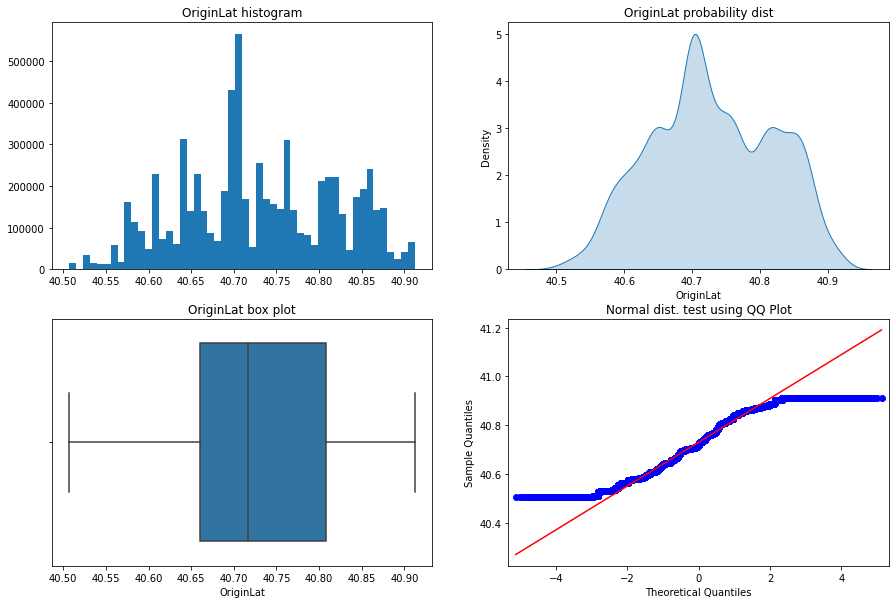

In [32]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['OriginLat'], bins=50)
a[0][0].set_title('OriginLat histogram')

sns.kdeplot(df['OriginLat'], bw_adjust=4.5, shade='blue', ax=a[0][1])
a[0][1].set_title('OriginLat probability dist')

sns.boxplot(x=df['OriginLat'], ax=a[1][0])
a[1][0].set_title('OriginLat box plot')

qqplot(df['OriginLat'], line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()



*   Origin Longitude column



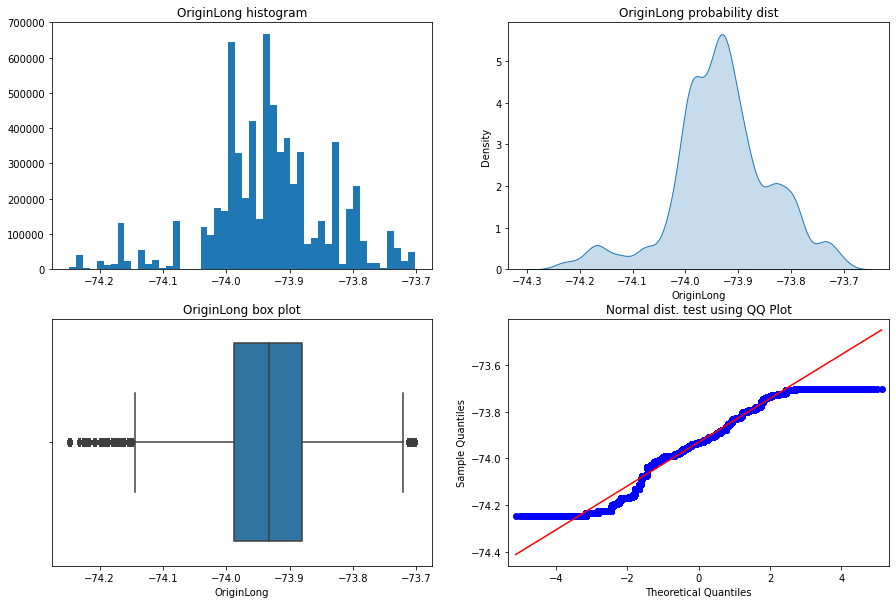

In [33]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['OriginLong'], bins=50)
a[0][0].set_title('OriginLong histogram')

sns.kdeplot(df['OriginLong'], bw_adjust=4.5, shade='blue', ax=a[0][1])
a[0][1].set_title('OriginLong probability dist')

sns.boxplot(x=df['OriginLong'], ax=a[1][0])
a[1][0].set_title('OriginLong box plot')

qqplot(df['OriginLong'], line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()



*   Destination Latitude column



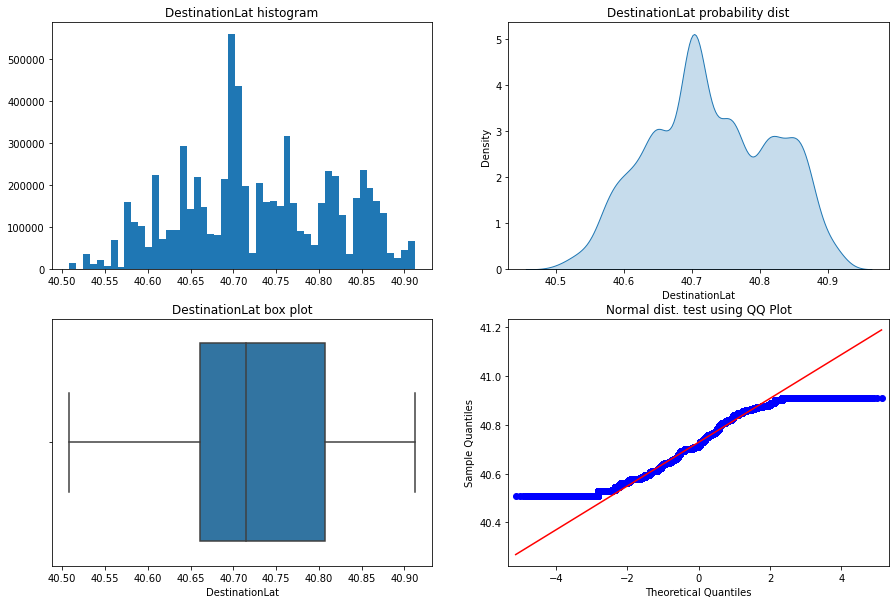

In [34]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['DestinationLat'], bins=50)
a[0][0].set_title('DestinationLat histogram')

sns.kdeplot(df['DestinationLat'], bw_adjust=4.5, shade='blue', ax=a[0][1])
a[0][1].set_title('DestinationLat probability dist')

sns.boxplot(x=df['DestinationLat'], ax=a[1][0])
a[1][0].set_title('DestinationLat box plot')

qqplot(df['DestinationLat'], line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()

*   Destination Longitude column data



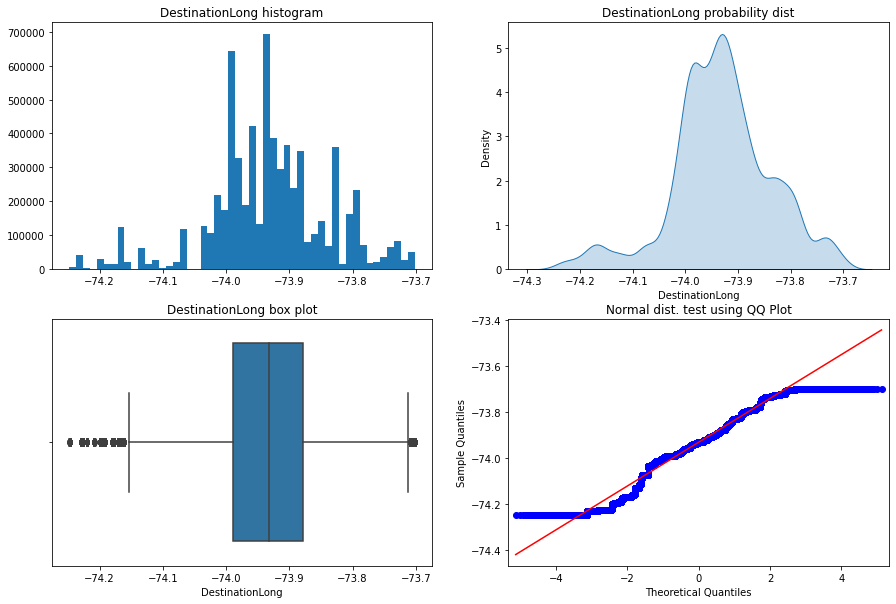

In [35]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['DestinationLong'], bins=50)
a[0][0].set_title('DestinationLong histogram')

sns.kdeplot(df['DestinationLong'], bw_adjust=4.5, shade='blue', ax=a[0][1])
a[0][1].set_title('DestinationLong probability dist')

sns.boxplot(x=df['DestinationLong'], ax=a[1][0])
a[1][0].set_title('DestinationLong box plot')

qqplot(df['DestinationLong'], line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()



*   Vehicle Location Latitude column





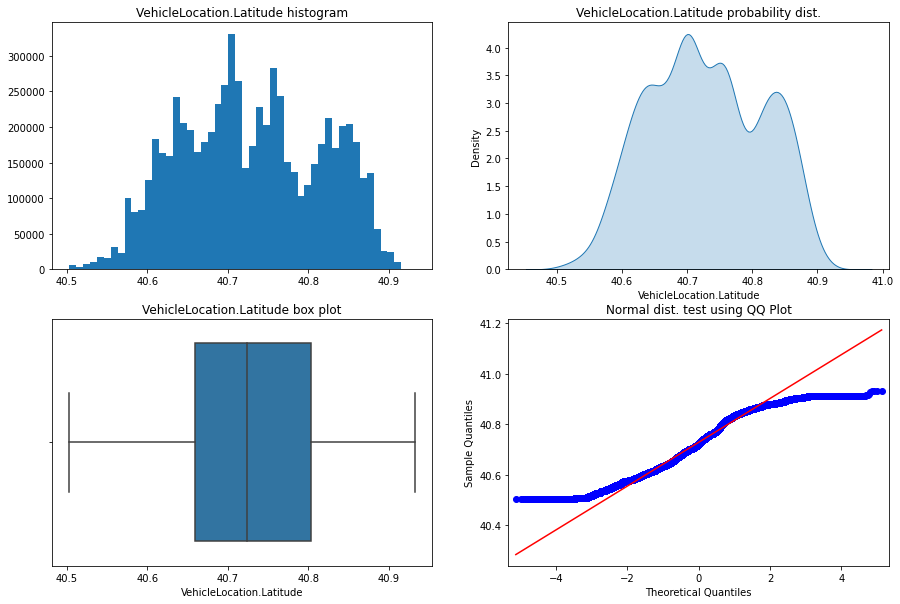

In [36]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['VehicleLocation.Latitude'], bins=50)
a[0][0].set_title('VehicleLocation.Latitude histogram')

sns.kdeplot(df['VehicleLocation.Latitude'], bw_adjust=4.5, shade='blue', ax=a[0][1])
a[0][1].set_title('VehicleLocation.Latitude probability dist.')

sns.boxplot(x=df['VehicleLocation.Latitude'], ax=a[1][0])
a[1][0].set_title('VehicleLocation.Latitude box plot')

qqplot(df['VehicleLocation.Latitude'], line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()



*   Vehicle Location Longitude column



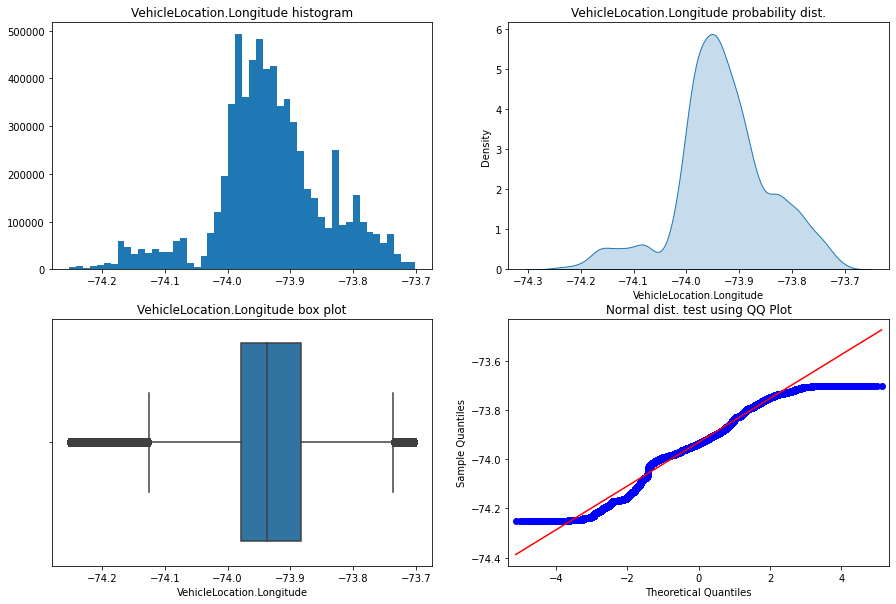

In [37]:
fig, a = plt.subplots(2, 2, figsize = (15, 10))

a[0][0].hist(df['VehicleLocation.Longitude'], bins=50)
a[0][0].set_title('VehicleLocation.Longitude histogram')

sns.kdeplot(df['VehicleLocation.Longitude'], bw_adjust=4.5, shade='blue', ax=a[0][1])
a[0][1].set_title('VehicleLocation.Longitude probability dist.')

sns.boxplot(x=df['VehicleLocation.Longitude'], ax=a[1][0])
a[1][0].set_title('VehicleLocation.Longitude box plot')

qqplot(df['VehicleLocation.Longitude'], line='s', ax=a[1][1])
a[1][1].set_title('Normal dist. test using QQ Plot')

plt.show()

The above plots show that, the data follows normal distribution although there is a slight deviation from the actual distribution owing to the presence of certain outliers and the fact that no real time data can be perfect. Adding to the above observations we've also pointed that the central tendency measures are all equal which is usually the case when the data follows a normal distribution.

To confirm that VehicleLocation.Longitude follows normal distribution, ks test is performed<br>
H0: Does not follow normal distribution<br>
H1: Follows a normal distribution

In [38]:
from scipy import stats

stats.kstest(df['VehicleLocation.Longitude'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

From the above test, we can observe that the null hypothesis is being rejected which implies that the VehicleLocation.Longitude follows a normal distribution. And an absolute 0.0(p value), is assumed to be a very small value which could be due to the size of the dataset and the presence of certain outliers.



---





*   Distance From Stop column



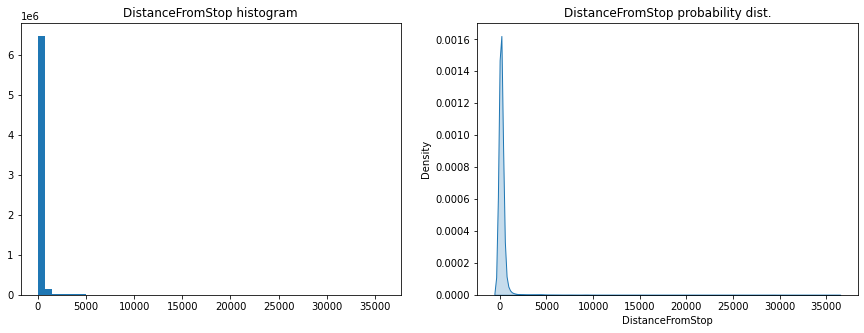

In [39]:
fig, a = plt.subplots(1, 2, figsize = (15, 5))

a[0].hist(df['DistanceFromStop'], bins=50)
a[0].set_title('DistanceFromStop histogram')

sns.kdeplot(df['DistanceFromStop'], bw_adjust=4.5, shade='blue', ax=a[1])
a[1].set_title('DistanceFromStop probability dist.')

plt.show()

The above plots show that DistanceFromStop follows an exponential distribution because the number of buses reaching the intended stop grows exponentially.



---



To find the frequency of buses on days of the week and hours of the day

In [40]:
df['RecordedAtTime']=pd.to_datetime(df['RecordedAtTime'])
df_temp=pd.DataFrame(df['RecordedAtTime'])
df_temp['Hour'] = df['RecordedAtTime'].dt.hour
df_temp['Date'] = df['RecordedAtTime'].dt.date
df_temp['Day'] = df['RecordedAtTime'].dt.day_name()

df_temp.head()

,RecordedAtTime,Hour,Date,Day
0,2017-06-01 00:03:34,0,2017-06-01,Thursday
1,2017-06-01 00:03:43,0,2017-06-01,Thursday
2,2017-06-01 00:03:49,0,2017-06-01,Thursday
3,2017-06-01 00:03:31,0,2017-06-01,Thursday
4,2017-06-01 00:03:22,0,2017-06-01,Thursday


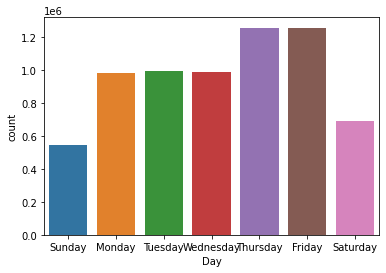

In [41]:
order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sns.countplot(x='Day', order=order, data=df_temp)
plt.show()

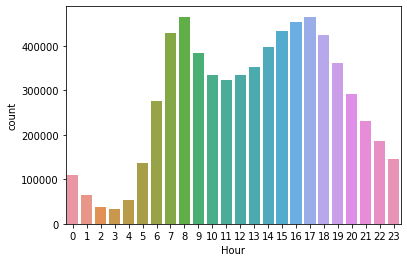

In [42]:
sns.countplot(x='Hour', data=df_temp)
plt.show()



---



To calculate the delay in reaching the next stop

In [ ]:
df['Delay'] = (df['ExpectedArrivalTime'] - df['ScheduledArrivalTime'])
df['Delay'] = df['Delay']/np.timedelta64(1, 'm')
df.loc[df['Delay'] < 0, 'Delay'] = 0

In [44]:
df.head(12)

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Delay
0,2017-06-01 00:03:34,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,40.635170,-73.960803,FOSTER AV/E 18 ST,approaching,76.0,2017-06-01 00:03:59,2017-06-01 00:06:14,0.000000
1,2017-06-01 00:03:43,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,40.590802,-74.158340,MERRYMOUNT ST/TRAVIS AV,approaching,62.0,2017-06-01 00:03:56,2017-05-31 23:58:02,5.900000
2,2017-06-01 00:03:49,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,40.886010,-73.912647,HENRY HUDSON PKY E/W 235 ST,at stop,5.0,2017-06-01 00:03:56,2017-06-01 00:00:53,3.050000
3,2017-06-01 00:03:31,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,40.668002,-73.729348,HOOK CREEK BL/SUNRISE HY,< 1 stop away,267.0,2017-06-01 00:04:03,2017-06-01 00:03:00,1.050000
4,2017-06-01 00:03:22,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,40.868134,-73.893032,GRAND CONCOURSE/E 196 ST,at stop,11.0,2017-06-01 00:03:56,2017-05-31 23:59:38,4.300000
5,2017-06-01 00:03:40,0,M1,4 AV/E 10 ST,40.731342,-73.990288,HARLEM 147 ST via MADISON,40.821110,-73.935898,NYCT_3831,40.792897,-73.950023,MADISON AV/E 106 ST,approaching,73.0,2017-06-01 00:03:56,2017-06-01 00:02:35,1.350000
6,2017-06-01 00:03:24,0,B31,GERRITSEN AV/GERRITSEN BEACH,40.587101,-73.918503,MIDWOOD KINGS HWY STA,40.608433,-73.957100,NYCT_4611,40.587024,-73.918623,GERRITSEN AV/GERRITSEN BEACH,at stop,0.0,2017-06-01 00:03:24,2017-06-01 00:08:00,0.000000
7,2017-06-01 00:03:29,0,B83,GATEWAY CTR TERM/GATEWAY DR,40.652649,-73.877029,BWAY JCT VN SNDRN AV,40.678139,-73.903572,NYCT_4841,40.648801,-73.882682,PENNSYLVANIA AV/DELMAR LOOP N,< 1 stop away,196.0,2017-06-01 00:04:13,2017-05-31 23:58:47,5.433333
8,2017-06-01 00:03:27,0,B82,STILLWELL TERMINAL BUS LOOP,40.577080,-73.981293,SPRING CRK TWRS SEAVIEW AV via KINGS HWY,40.642990,-73.878326,NYCT_6592,40.632258,-73.918318,FLATLANDS AV/RALPH AV,approaching,35.0,2017-06-01 00:03:56,2017-06-01 00:00:00,3.933333
9,2017-06-01 00:03:51,1,S59,RICHMOND TER/PARK AV #3,40.640167,-74.130966,HYLAN BL,40.534260,-74.154213,NYCT_8279,40.590689,-74.165811,RICHMOND AV/NOME AV,approaching,31.0,2017-06-01 00:03:56,2017-06-01 00:01:14,2.700000


To calculate the average delay one could expect on different days of the week

RecordedAtTime
Monday       4.847691
Tuesday      5.489396
Thursday     6.216857
Wednesday    6.329653
Friday       6.467868
Sunday       6.847567
Saturday     6.979578
Name: Delay, dtype: float64


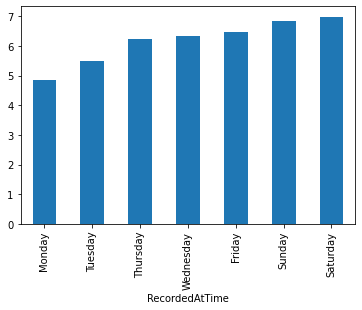

In [45]:
df_delay = df.groupby(df['RecordedAtTime'].dt.day_name())['Delay'].mean().sort_values()
print(df_delay)
df_delay.plot.bar()

The above plot shows that the delay is maximum during the weekend(Saturday, Sunday), moderate during the mid week(Wednesday, Thursday, Friday) and slightly lesser during the start of the week(Monday, Tuesday).

To find the busiest line

In [46]:
df.loc[df['Delay'] == df['Delay'].max()]

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Delay
5722618,2017-06-26 22:16:08,1,Bx6,FOOD CENTER DR/MARKET ST,40.810043,-73.876694,RIVERSIDE DR,40.836205,-73.948479,NYCT_7706,40.820484,-73.891037,HUNTS POINT AV/E 163 ST,approaching,67.0,2017-06-26 22:16:38,2017-06-26 17:16:00,300.633333


To find the line with minimum traffic

In [47]:
df.loc[df['Delay'] == df['Delay'].min()]

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Delay
0,2017-06-01 00:03:34,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,40.635170,-73.960803,FOSTER AV/E 18 ST,approaching,76.0,2017-06-01 00:03:59,2017-06-01 00:06:14,0.0
6,2017-06-01 00:03:24,0,B31,GERRITSEN AV/GERRITSEN BEACH,40.587101,-73.918503,MIDWOOD KINGS HWY STA,40.608433,-73.957100,NYCT_4611,40.587024,-73.918623,GERRITSEN AV/GERRITSEN BEACH,at stop,0.0,2017-06-01 00:03:24,2017-06-01 00:08:00,0.0
11,2017-06-01 00:03:52,1,B1,87 ST/4 Av,40.621925,-74.028496,MANHATTAN BEACH KINGSBORO CC,40.578094,-73.940170,NYCT_7141,40.602164,-73.994162,86 ST/BAY PY,at stop,22.0,2017-06-01 00:03:57,2017-06-01 00:05:55,0.0
12,2017-06-01 00:03:35,1,B26,WYCKOFF ST/PALMETTO ST,40.699150,-73.910477,DNTWN BKLYN TILLARY ST via HALSEY,40.693939,-73.990311,NYCT_6503,40.693922,-73.990411,CADMAN PZ W/TILLARY ST,approaching,47.0,2017-06-01 00:03:35,2017-06-01 00:03:35,0.0
15,2017-06-01 00:03:36,1,Bx31,VAN CORTLANDT PK E/E 242 ST,40.902660,-73.868378,WESTCHESTER SQ,40.841076,-73.842850,NYCT_274,40.841608,-73.843465,TREMONT AV/LANE AV,approaching,78.0,2017-06-01 00:03:55,2017-06-01 00:05:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6730403,2017-06-30 23:53:34,0,Q12,ROOSEVELT AV/LAYOVER,40.758999,-73.831757,LITTLE NECK GLENWOOD ST VIA NORTHERN,40.771767,-73.733307,NYCT_4479,40.766541,-73.739721,NORTHERN BL/248 ST,approaching,42.0,2017-06-30 23:53:38,2017-06-30 23:57:05,0.0
6730408,2017-06-30 23:53:18,1,S79-SBS,4 AV/86 ST,40.622658,-74.028343,SELECT BUS SERVICE SI MALL via HYLAN,40.583351,-74.161812,NYCT_4245,40.594581,-74.086493,HYLAN BL/SEAVIEW AV,0.7 miles away,1051.0,2017-06-30 23:56:08,2017-06-30 23:56:44,0.0
6730411,2017-06-30 23:53:33,1,Q36,256 ST/JAMAICA AV,40.727776,-73.708687,JAMAICA 165 ST TERM,40.707615,-73.795540,NYCT_6486,40.707646,-73.795448,165 ST TERM/165 ST TERM BAY 6,at stop,0.0,2017-06-30 23:53:33,2017-06-30 23:53:33,0.0
6730430,2017-06-30 23:53:20,0,Bx11,W 179 ST/BROADWAY,40.849113,-73.937752,W FARMS RD SOUTHERN BL,40.825272,-73.891426,NYCT_700,40.840354,-73.922210,W 170 ST/EDWARD L GRANT HY,approaching,123.0,2017-06-30 23:54:13,2017-07-01 00:09:34,0.0




---



To find the distance between the Origins and the Bus locations.

In [48]:
from math import radians, cos, sin, asin, sqrt

df_dist = df[['OriginLat', 'OriginLong', 'VehicleLocation.Latitude', 'VehicleLocation.Longitude']]

diff_lat = df['VehicleLocation.Latitude'].apply(radians) - df['OriginLat'].apply(radians)
diff_long = df['VehicleLocation.Longitude'].apply(radians) - df['OriginLong'].apply(radians)

a = (diff_lat.apply(sin) / 2)**2 + (df['OriginLat'].apply(radians)).apply(cos) * (df['VehicleLocation.Latitude'].apply(radians)).apply(cos) * (diff_long.apply(sin) / 2)**2

c = 2 * (a.apply(sqrt)).apply(asin)
r = 6371

dist = c*r

df_dist['Distance'] = dist

df_dist.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,OriginLat,OriginLong,VehicleLocation.Latitude,VehicleLocation.Longitude,Distance
0,40.616104,-74.031143,40.635170,-73.960803,6.303533
1,40.643169,-74.073494,40.590802,-74.158340,9.230031
2,40.875008,-73.880142,40.886010,-73.912647,2.994090
3,40.701748,-73.802399,40.668002,-73.729348,7.212602
4,40.881187,-73.909340,40.868134,-73.893032,1.996681


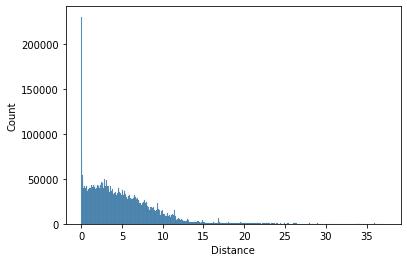

In [49]:
sns.histplot(df_dist['Distance']);
plt.show()

The above plot shows that the buses are located quite closer to the origins.

To check if there exists a relation between the Origins and the Bus locations using 2 tailed t-test<br>
H0 - They are not related<br>
H1 - Maybe they are related

In [50]:
from scipy import stats

def ttest(col1,col2):
    len1 = len(col1)
    len2 = len(col2)

    dof = len1 + len2 - 2

    alpha = 0.05
    two_tailed_test_prob_tail = alpha/2
    t_critical = round(stats.t.ppf(two_tailed_test_prob_tail, dof), 3)
    print('t-critical: ', t_critical)
    
    tval, pval = stats.ttest_ind(a=col1, b=col2, equal_var=False, nan_policy='omit')
    print('t-value: ', tval)
    print('p-value: ', pval)

    # Compare the p-value with the threshold value 0.05(alpha value or confidence level)
    if pval < 0.05:
        print("Reject null hypothesis i.e, there might be a relation between the two")
    else:
        print("Accept null hypothesis i.e, there might not be any relation between the two")

In [51]:
col1 = df_dist['OriginLat']
col2 = df_dist['VehicleLocation.Latitude']

ttest(col1,col2)

t-critical:  -1.96
t-value:  23.358481479151965
p-value:  1.1363965106573582e-120
Reject null hypothesis i.e, there might be a relation between the two


In [52]:
col1 = df['OriginLong']
col2 = df['VehicleLocation.Longitude']

ttest(col1, col2)

t-critical:  -1.96
t-value:  -7.967196497237545
p-value:  1.6232702782812486e-15
Reject null hypothesis i.e, there might be a relation between the two


The above two results show that there is some kind of a relation between the Origins and bus locations and is not a mere coincidence.

Relationship Analysis using Covariance and Correlation

In [53]:
def cov_and_corr(col1, col2):
    print('Covariance: ', col1.cov(col2))
    print('Correlation: ', col1.corr(col2))

In [54]:
cov_and_corr(df['OriginLat'], df['VehicleLocation.Latitude'])

Covariance:  0.0068037043326071855
Correlation:  0.8722050585283414


In [55]:
cov_and_corr(df['OriginLong'], df['VehicleLocation.Longitude'])

Covariance:  0.007072432322829774
Correlation:  0.8455603216348153


Although the covariance is a very small value, the corrrelation value is very high which shows that there exists a stronger relation between the two and the lower value of covariance might be due to the presence of large range of values in the columns.

**Regression analysis** over the Origin and Bus locations.

In [56]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def linear_regression(col1, col2):
    X = col1.values.reshape(-1,1)
    y = col2.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
    print('Linear Regression\n')
    print('R2 score: ', model.score(X_test, y_test))
    
    print('Intercept: ',model.intercept_ , 'slope: ',model.coef_)

    y_pred = model.predict(X_test)

    df_test = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
    print(df_test.head())

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

    plt.scatter(X_test, y_test)
    plt.plot(X_test, y_pred, color='red', linewidth=2)
    plt.show()

In [57]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LassoCV
from sklearn import metrics

def l1_regularize(col1, col2):
    X = col1.values.reshape(-1,1)
    y = col2.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    model = LassoCV().fit(X_train, y_train)
    print('L1-regularization\n')
    print('R2 score: ', model.score(X_test, y_test))
    
    print('Intercept: ',model.intercept_ , 'slope: ',model.coef_)

    y_pred = model.predict(X_test)

    df_test = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
    print(df_test.head())

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn import metrics

def l2_regularize(col1, col2):
    X = col1.values.reshape(-1,1)
    y = col2.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    model = Ridge().fit(X_train, y_train)
    print('L2-regularization\n')
    print('R2 score: ', model.score(X_test, y_test))
    
    print('Intercept: ',model.intercept_ , 'slope: ',model.coef_)

    y_pred = model.predict(X_test)

    df_test = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
    print(df_test.head())

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Linear Regression

R2 score:  0.7607903790442169
Intercept:  6.404008285551043 slope:  [0.84274033]
      Actual  Predicted
0  40.828773  40.811629
1  40.810618  40.856233
2  40.667730  40.703463
3  40.766528  40.770145
4  40.857864  40.874329
Mean Absolute Error: 0.03002604222842437
Mean Squared Error: 0.0018034920113426456
Root Mean Squared Error: 0.042467540679236956


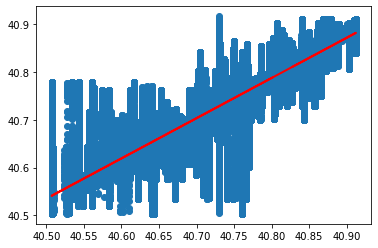

In [59]:
linear_regression(df_dist['OriginLat'], df_dist['VehicleLocation.Latitude'])

In [60]:
l1_regularize(df_dist['OriginLat'], df_dist['VehicleLocation.Latitude'])

L1-regularization

R2 score:  0.7607892009835929
Intercept:  6.438332764272602 slope:  [0.84189759]
      Actual  Predicted
0  40.828773  40.811546
1  40.810618  40.856106
2  40.667730  40.703488
3  40.766528  40.770103
4  40.857864  40.874184
Mean Absolute Error: 0.030037862597288755
Mean Squared Error: 0.0018035008931882655
Root Mean Squared Error: 0.04246764525127648


In [61]:
l2_regularize(df_dist['OriginLat'], df_dist['VehicleLocation.Latitude'])

L2-regularization

R2 score:  0.7607903690330489
Intercept:  6.404797908583326 slope:  [0.84272094]
      Actual  Predicted
0  40.828773  40.811627
1  40.810618  40.856230
2  40.667730  40.703464
3  40.766528  40.770144
4  40.857864  40.874326
Mean Absolute Error: 0.03002631231645048
Mean Squared Error: 0.0018034920868206363
Root Mean Squared Error: 0.042467541567892016


Linear Regression

R2 score:  0.7149139156901281
Intercept:  -14.562926895714028 slope:  [0.80301497]
      Actual  Predicted
0 -73.928095 -73.927055
1 -73.927810 -73.913234
2 -73.980879 -73.976055
3 -73.982429 -73.971913
4 -73.843480 -73.880340
Mean Absolute Error: 0.034589795780587705
Mean Squared Error: 0.002267915096792444
Root Mean Squared Error: 0.04762263219092834


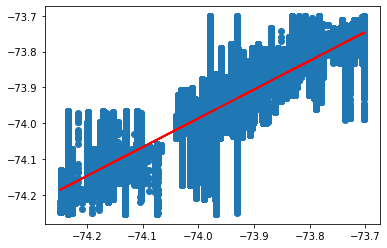

In [62]:
linear_regression(df_dist['OriginLong'], df_dist['VehicleLocation.Longitude'])

In [63]:
l1_regularize(df_dist['OriginLong'], df_dist['VehicleLocation.Longitude'])

L1-regularization

R2 score:  0.7149108333056502
Intercept:  -14.622294672497574 slope:  [0.80221196]
      Actual  Predicted
0 -73.928095 -73.927059
1 -73.927810 -73.913251
2 -73.980879 -73.976010
3 -73.982429 -73.971872
4 -73.843480 -73.880391
Mean Absolute Error: 0.034592166764292734
Mean Squared Error: 0.0022679396177588333
Root Mean Squared Error: 0.047622889640999665


In [64]:
l2_regularize(df_dist['OriginLong'], df_dist['VehicleLocation.Longitude'])

L2-regularization

R2 score:  0.7149138654038738
Intercept:  -14.564178699843026 slope:  [0.80299804]
      Actual  Predicted
0 -73.928095 -73.927055
1 -73.927810 -73.913234
2 -73.980879 -73.976054
3 -73.982429 -73.971912
4 -73.843480 -73.880341
Mean Absolute Error: 0.034589844970133336
Mean Squared Error: 0.0022679154968293504
Root Mean Squared Error: 0.047622636390999507


From the above linear regression analysis, we found that, the goodness of fit measure(R2 score) is quite high and the error measurements are less hence proving that there is a relation between the Origins and the Vehicle Locations.
From the l1 and l2 regularization values we can also conclude that the linear curve was an optimal fit curve since the R2 score is approximately the same as the linear regression's R2 score.